# Project: Segmentation map to Realimage
## pix2pix: Image-to-Image translation
data link : https://d3s0tskafalll9.cloudfront.net/media/documents/cityscapes.zip  
  
goal :  
![img1](asset/img1.png)

# 1. Load and Check data

In [6]:
import os
train_data_path = 'cityscapes/train/'
val_data_path = 'cityscapes/val'
print("number of train examples :", len(os.listdir(train_data_path)))
print("number of validation examples :", len(os.listdir(val_data_path)))

number of train examples : 1000
number of validation examples : 5


## 1.1 Print images

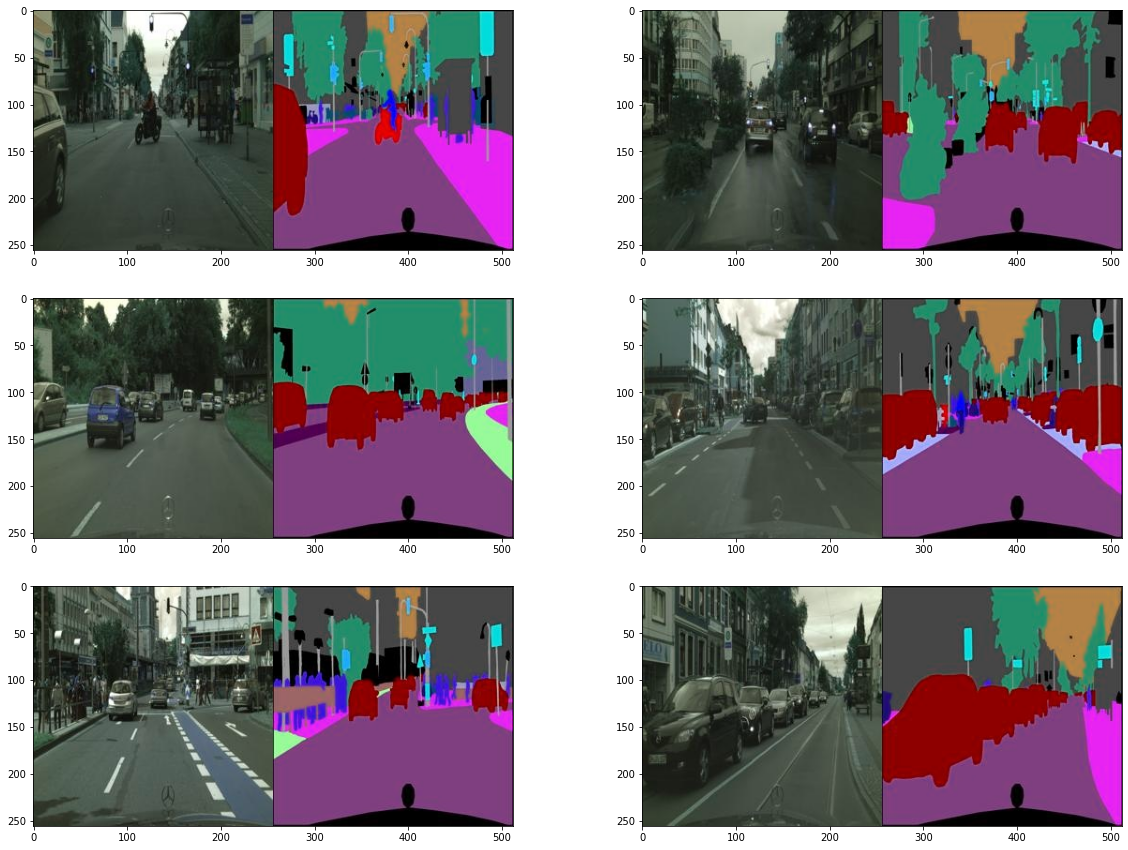

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(20,15))

for i in range(1, 7):
    f = data_path + os.listdir(data_path)[np.random.randint(1000)]
    img = cv2.imread(f, cv2.IMREAD_COLOR)
    plt.subplot(3,2,i)
    plt.imshow(img)

## 1.2 Check image size

In [5]:
f = data_path + os.listdir(data_path)[0]
img = cv2.imread(f, cv2.IMREAD_COLOR)
print(img.shape)

(256, 512, 3)


## 1.3 Data Preprocessing

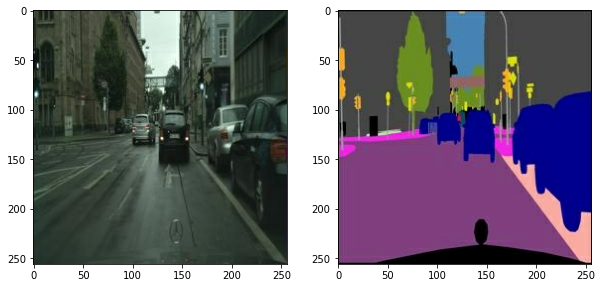

In [8]:
import tensorflow as tf

def normalize(x):
    x = tf.cast(x, tf.float32)
    return (x/127.5) - 1

def denormalize(x):
    x = (x+1)*127.5
    x = x.numpy()
    return x.astype(np.uint8)

def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, 3)
    
    w = tf.shape(img)[1] // 2
    
    real_img = img[:, :w, :]
    real_img = tf.cast(real_img, tf.float32)
    
    segment_img = img[:, w:, :]
    segment_img = tf.cast(segment_img, tf.float32)
    
    return normalize(real_img), normalize(segment_img)


f = data_path + os.listdir(train_data_path)[1]
real, segment = load_img(f)

plt.figure(figsize=(10,7))
plt.subplot(1,2,1); plt.imshow(denormalize(real))
plt.subplot(1,2,2); plt.imshow(denormalize(segment))

## 1.4 Data augment

In [9]:
from tensorflow import image
from tensorflow.keras.preprocessing.image import random_rotation

@tf.function()
def apply_augmentation(sketch, colored):
    stacked = tf.concat([sketch, colored], axis=-1)
    
    _pad = tf.constant([[30,30],[30,30],[0,0]])
    if tf.random.uniform(()) < .5:
        padded = tf.pad(stacked, _pad, "REFLECT")
    else:
        padded = tf.pad(stacked, _pad, "CONSTANT", constant_values=1.)

    out = image.random_crop(padded, size=[256, 256, 6])
    
    
    out = image.random_flip_left_right(out)
    out = image.random_flip_up_down(out)
    
    if tf.random.uniform(()) < .5:
        degree = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32)
        out = image.rot90(out, k=degree)
    
    return out[...,:3], out[...,3:]  

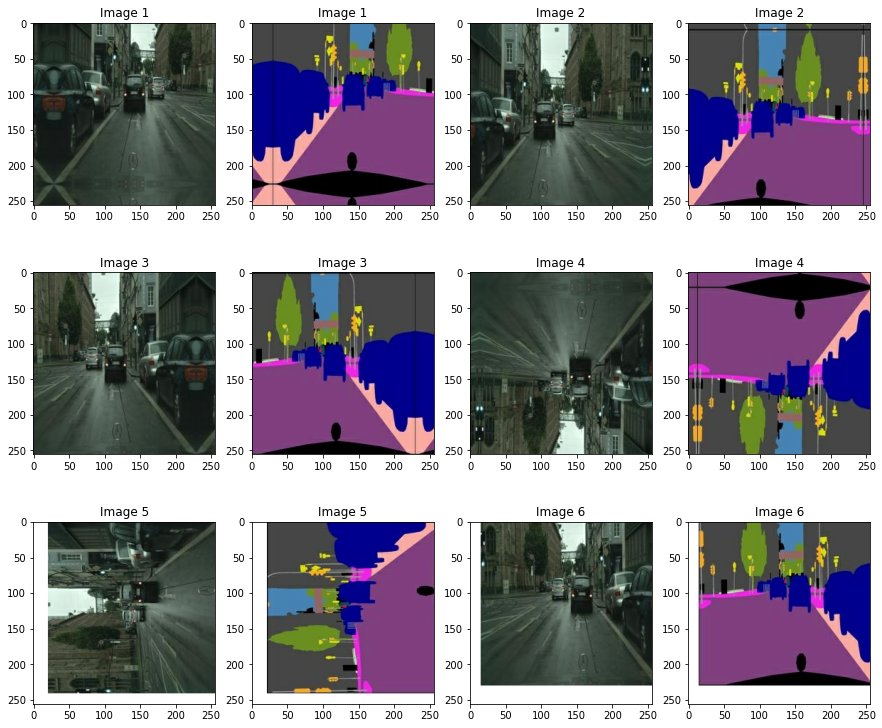

In [11]:
plt.figure(figsize=(15,13))
img_n = 1
for i in range(1, 13, 2):
    augmented_sketch, augmented_colored = apply_augmentation(real, segment)
    
    plt.subplot(3,4,i)
    plt.imshow(denormalize(augmented_sketch)); plt.title(f"Image {img_n}")
    plt.subplot(3,4,i+1); 
    plt.imshow(denormalize(augmented_colored)); plt.title(f"Image {img_n}")
    img_n += 1

In [32]:
from tensorflow import data

def get_train(img_path):
    real, seg = load_img(img_path)
    real, seg = apply_augmentation(real, seg)
    return real, seg

train_images = data.Dataset.list_files(train_data_path + "*.jpg")
train_images = train_images.map(get_train).shuffle(100).batch(4)

# 3 Build Model
## 3.1 Generator
Build U-net Encoder Decoder

### Encoder

In [12]:
from tensorflow.keras import layers, Input, Model

class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu= layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

In [13]:
class Encoder(layers.Layer):
    def __init__(self):
        super(Encoder, self).__init__()
        filters = [64,128,256,512,512,512,512,512]
        
        self.blocks = []
        for i in filters:
            if i!=64:
                self.blocks.append(EncodeBlock(i))
            else:
                self.blocks.append(EncodeBlock(i,False))
    
    def call(self, x):
        for block in self.blocks:
            x = block(x)
        return x
    
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

In [16]:
Encoder().get_summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
encode_block_8 (EncodeBlock) (None, 128, 128, 64)      3072      
_________________________________________________________________
encode_block_9 (EncodeBlock) (None, 64, 64, 128)       131584    
_________________________________________________________________
encode_block_10 (EncodeBlock (None, 32, 32, 256)       525312    
_________________________________________________________________
encode_block_11 (EncodeBlock (None, 16, 16, 512)       2099200   
_________________________________________________________________
encode_block_12 (EncodeBlock (None, 8, 8, 512)         4196352   
_________________________________________________________________
encode_block_13 (EncodeBlock (None, 4, 4, 512)         4196

### Decoder

In [14]:
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)

In [17]:
class Decoder(layers.Layer):
    def __init__(self):
        super(Decoder, self).__init__()
        filters = [512,512,512,512,256,128,64]
        
        self.blocks = []
        count = 0
        for i in filters:
            if count <= 2:
                self.blocks.append(DecodeBlock(i))
            else:
                self.blocks.append(DecodeBlock(i, False))
        self.blocks.append(layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False))
    def call(self, x):
        for block in self.blocks:
            x = block(x)
        return x
            
    def get_summary(self, input_shape=(1,1,512)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

In [18]:
Decoder().get_summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 1, 1, 512)]       0         
_________________________________________________________________
decode_block (DecodeBlock)   (None, 2, 2, 512)         4196352   
_________________________________________________________________
decode_block_1 (DecodeBlock) (None, 4, 4, 512)         4196352   
_________________________________________________________________
decode_block_2 (DecodeBlock) (None, 8, 8, 512)         4196352   
_________________________________________________________________
decode_block_3 (DecodeBlock) (None, 16, 16, 512)       4196352   
_________________________________________________________________
decode_block_4 (DecodeBlock) (None, 32, 32, 256)       2098176   
_________________________________________________________________
decode_block_5 (DecodeBlock) (None, 64, 64, 128)       5248

In [20]:
class UNetGenerator(Model):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        encode_filters = [64,128,256,512,512,512,512,512]
        decode_filters = [512,512,512,512,256,128,64]
        
        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock(f))
        
        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout=False))
        
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)
    
    def call(self, x):
        features = []
        for block in self.encode_blocks:
            x = block(x)
            features.append(x)
        
        features = features[:-1]
                    
        for block, feat in zip(self.decode_blocks, features[::-1]):
            x = block(x)
            x = layers.Concatenate()([x, feat])
        
        x = self.last_conv(x)
        return x
                
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

In [21]:
UNetGenerator().get_summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
encode_block_16 (EncodeBlock)   (None, 128, 128, 64) 3072        input_4[0][0]                    
__________________________________________________________________________________________________
encode_block_17 (EncodeBlock)   (None, 64, 64, 128)  131584      encode_block_16[0][0]            
__________________________________________________________________________________________________
encode_block_18 (EncodeBlock)   (None, 32, 32, 256)  525312      encode_block_17[0][0]            
____________________________________________________________________________________________

# 3.2 Discriminator

In [25]:
class DiscBlock(layers.Layer):
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act
        
        if custom_pad:
            self.padding = layers.ZeroPadding2D()
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid", use_bias=False)
        else:
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)
        
        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None
        
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
                
        if self.use_bn:
            x = self.batchnorm(x)
            
        if self.act:
            x = self.lrelu(x)
        return x 

In [26]:
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        filters = [64, 128, 256, 512, 1]
        self.blocks = []  
       
        self.blocks.append(layers.InputLayer(input_shape=(256, 256, 6))) 
        
        for i, f in enumerate(filters):
            stride = 2 if i < 3 else 1
            custom_pad = i >= 3
            use_bn = i != 0 and i != 4
            act = i != 4
            
            self.blocks.append(DiscBlock(n_filters=f, stride=stride, custom_pad=custom_pad, use_bn=use_bn, act=act))
        
        
        self.sigmoid = layers.Activation('sigmoid')

    def call(self, x, y):
        out = layers.Concatenate()([x, y])  
        for block in self.blocks:
            out = block(out)
        return self.sigmoid(out)

    def get_summary(self, x_shape=(256, 256, 3), y_shape=(256, 256, 3)):
        x, y = Input(x_shape), Input(y_shape)
        return Model((x, y), self.call(x, y)).summary()

In [27]:
Discriminator().get_summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
concatenate_7 (Concatenate)     (None, 256, 256, 6)  0           input_6[0][0]                    
                                                                 input_7[0][0]                    
__________________________________________________________________________________________________
input_5 (InputLayer)            multiple             0           concatenate_7[0][0]        

# 4. Train Model

In [22]:
from tensorflow.keras import losses
from tensorflow.keras import optimizers

bce = losses.BinaryCrossentropy(from_logits=False)
mae = losses.MeanAbsoluteError()

gene_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
disc_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)

In [23]:
def get_gene_loss(fake_output, real_output, fake_disc):
    l1_loss = mae(real_output, fake_output)
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    return gene_loss, l1_loss

def get_disc_loss(fake_disc, real_disc):
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)

@tf.function
def train_step(sketch, real_colored):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        
        fake_colored = generator(sketch, training=True)
        
        fake_disc = discriminator(sketch, fake_colored, training=True)
        real_disc = discriminator(sketch, real_colored, training=True)
        
        gene_loss, l1_loss = get_gene_loss(fake_colored, real_colored, fake_disc)
        gene_total_loss = gene_loss + (100 * l1_loss) 
        
        disc_loss = get_disc_loss(fake_disc, real_disc)
                
    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gene_loss, l1_loss, disc_loss

In [33]:
import matplotlib.pyplot as plt

EPOCHS = 10

generator = UNetGenerator()
discriminator = Discriminator()

# 리스트를 생성하여 손실값을 저장합니다.
generator_losses = []
l1_losses = []
discriminator_losses = []

for epoch in range(1, EPOCHS+1):
    for i, (sketch, colored) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(sketch, colored)

        # 손실값을 리스트에 추가
        generator_losses.append(g_loss.numpy())
        l1_losses.append(l1_loss.numpy())
        discriminator_losses.append(d_loss.numpy())

        # 10회 반복마다 손실을 출력합니다.
        if (i+1) % 10 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

EPOCH[1] - STEP[10]                     
Generator_loss:0.8829                     
L1_loss:0.3692                     
Discriminator_loss:1.1013

EPOCH[1] - STEP[20]                     
Generator_loss:1.0977                     
L1_loss:0.2752                     
Discriminator_loss:1.3072

EPOCH[1] - STEP[30]                     
Generator_loss:1.0814                     
L1_loss:0.2767                     
Discriminator_loss:1.0698

EPOCH[1] - STEP[40]                     
Generator_loss:1.3308                     
L1_loss:0.2280                     
Discriminator_loss:1.0507

EPOCH[1] - STEP[50]                     
Generator_loss:1.6443                     
L1_loss:0.2374                     
Discriminator_loss:0.6842

EPOCH[1] - STEP[60]                     
Generator_loss:1.7516                     
L1_loss:0.2307                     
Discriminator_loss:0.6237

EPOCH[1] - STEP[70]                     
Generator_loss:1.5622                     
L1_loss:0.2500                    

EPOCH[3] - STEP[70]                     
Generator_loss:2.3417                     
L1_loss:0.1862                     
Discriminator_loss:2.2524

EPOCH[3] - STEP[80]                     
Generator_loss:2.0529                     
L1_loss:0.2549                     
Discriminator_loss:0.3048

EPOCH[3] - STEP[90]                     
Generator_loss:2.9824                     
L1_loss:0.1912                     
Discriminator_loss:1.6528

EPOCH[3] - STEP[100]                     
Generator_loss:1.1521                     
L1_loss:0.1757                     
Discriminator_loss:0.6039

EPOCH[3] - STEP[110]                     
Generator_loss:1.1647                     
L1_loss:0.2355                     
Discriminator_loss:1.0190

EPOCH[3] - STEP[120]                     
Generator_loss:2.1651                     
L1_loss:0.2218                     
Discriminator_loss:0.3826

EPOCH[3] - STEP[130]                     
Generator_loss:1.4743                     
L1_loss:0.2043                

EPOCH[5] - STEP[130]                     
Generator_loss:0.4369                     
L1_loss:0.1915                     
Discriminator_loss:1.5210

EPOCH[5] - STEP[140]                     
Generator_loss:2.4339                     
L1_loss:0.1432                     
Discriminator_loss:1.1301

EPOCH[5] - STEP[150]                     
Generator_loss:1.2538                     
L1_loss:0.1818                     
Discriminator_loss:0.7851

EPOCH[5] - STEP[160]                     
Generator_loss:0.7945                     
L1_loss:0.1849                     
Discriminator_loss:1.0789

EPOCH[5] - STEP[170]                     
Generator_loss:1.6751                     
L1_loss:0.1650                     
Discriminator_loss:0.9906

EPOCH[5] - STEP[180]                     
Generator_loss:2.3621                     
L1_loss:0.2484                     
Discriminator_loss:0.3653

EPOCH[5] - STEP[190]                     
Generator_loss:1.3356                     
L1_loss:0.1654             

EPOCH[7] - STEP[190]                     
Generator_loss:1.3819                     
L1_loss:0.2235                     
Discriminator_loss:0.5284

EPOCH[7] - STEP[200]                     
Generator_loss:2.1826                     
L1_loss:0.1922                     
Discriminator_loss:0.2266

EPOCH[7] - STEP[210]                     
Generator_loss:1.5970                     
L1_loss:0.2299                     
Discriminator_loss:0.3566

EPOCH[7] - STEP[220]                     
Generator_loss:1.2532                     
L1_loss:0.1977                     
Discriminator_loss:0.4681

EPOCH[7] - STEP[230]                     
Generator_loss:2.7683                     
L1_loss:0.1673                     
Discriminator_loss:0.9292

EPOCH[7] - STEP[240]                     
Generator_loss:1.2069                     
L1_loss:0.2035                     
Discriminator_loss:0.6169

EPOCH[7] - STEP[250]                     
Generator_loss:2.5539                     
L1_loss:0.2021             

EPOCH[9] - STEP[250]                     
Generator_loss:1.4005                     
L1_loss:0.1617                     
Discriminator_loss:0.7350

EPOCH[10] - STEP[10]                     
Generator_loss:0.4953                     
L1_loss:0.1708                     
Discriminator_loss:1.4557

EPOCH[10] - STEP[20]                     
Generator_loss:2.1891                     
L1_loss:0.1988                     
Discriminator_loss:1.1822

EPOCH[10] - STEP[30]                     
Generator_loss:1.9115                     
L1_loss:0.2024                     
Discriminator_loss:1.2325

EPOCH[10] - STEP[40]                     
Generator_loss:2.3182                     
L1_loss:0.1528                     
Discriminator_loss:0.5069

EPOCH[10] - STEP[50]                     
Generator_loss:1.0569                     
L1_loss:0.1462                     
Discriminator_loss:0.7625

EPOCH[10] - STEP[60]                     
Generator_loss:0.8154                     
L1_loss:0.2081             

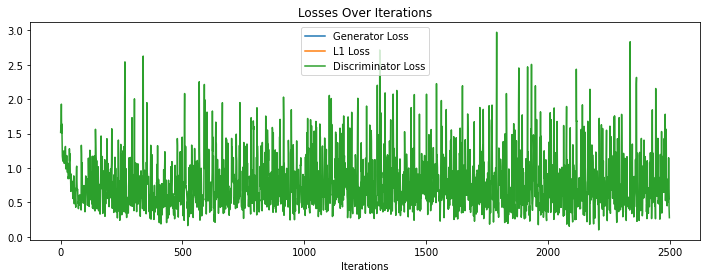

In [35]:
plt.figure(figsize=(12, 4))

plt.plot(g_loss, label="Generator Loss")
plt.plot(l1_loss, label="L1 Loss")
plt.plot(discriminator_losses, label="Discriminator Loss")

plt.title("Losses Over Iterations")
plt.xlabel("Iterations")
plt.legend()
plt.show()

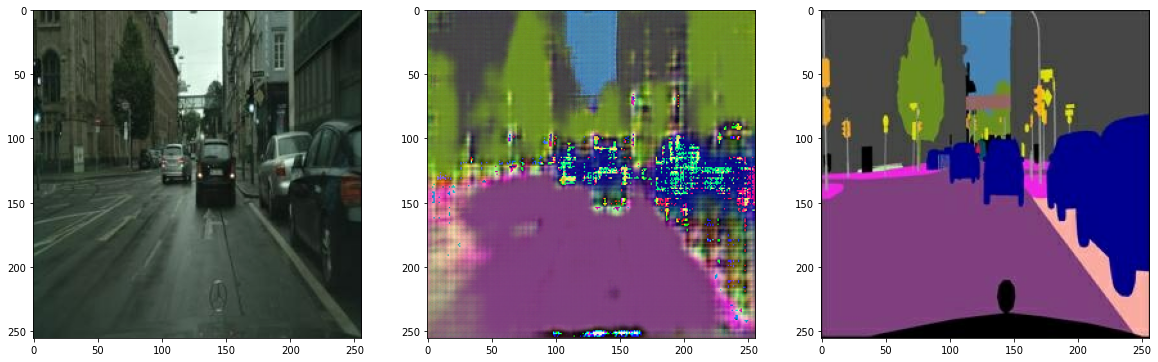

In [39]:
test_ind = 1

f = data_path + os.listdir(train_data_path)[test_ind]
real, seg = load_img(f)

pred = generator(tf.expand_dims(real, 0))
pred = denormalize(pred)

plt.figure(figsize=(20,10))
plt.subplot(1,3,1); plt.imshow(denormalize(real))
plt.subplot(1,3,2); plt.imshow(pred[0])
plt.subplot(1,3,3); plt.imshow(denormalize(seg))